In [22]:
# display feature maps that ar outputs by convolutional and pooling layers of the network given a certain input, giving a view of how the input is decomposed into the filters learned by the network.
# Plotting independently the contents of every channel as a 2D image.

In [23]:
from keras.models import load_model
from keras.utils import load_img, img_to_array, array_to_img
import numpy as np
import matplotlib.pyplot as plt
from keras import models
import os

In [24]:
# customized metrics

from keras import backend as K

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [25]:
model = load_model(os.path.join("..","models","CNN_dropout_batch_bigger_class_weights.h5"),custom_objects = {"precision": precision, "recall": recall})

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 69, 69, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 34, 34, 32)       128       
 hNormalization)                                                 
                                                        

(1, 69, 69, 3)


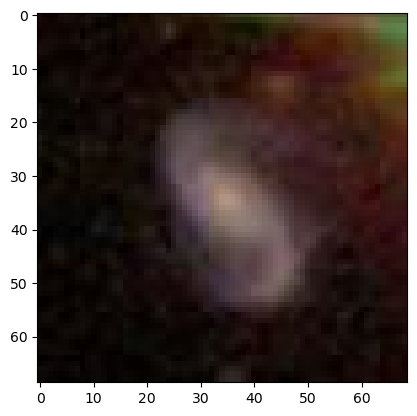

In [35]:
img_path = os.path.join('..','workspace', 'images', 'all','7073.jpg')

# select an image not used for training
input_height = int(69)
input_width = int(69)

img = load_img(img_path, target_size=(input_height, input_width))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 69, 69, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 34, 34, 32)       128       
 hNormalization)                                                 
                                                        

In [36]:
num_layers = 12 # extract the outputs of the top num_layers layers
layer_outputs = [layer.output for layer in model.layers[:num_layers]]
# creates a model thaat will return these outputs given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [37]:
# return one array per laayer activation
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 1s 975ms/step


(1, 69, 69, 16)


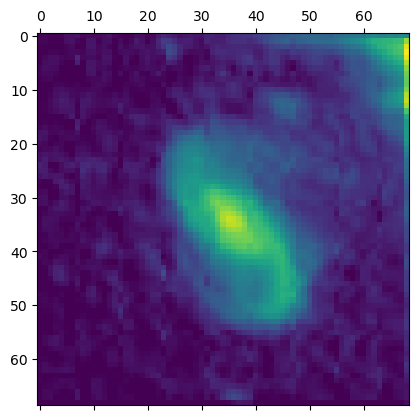

In [38]:
# e.g. first layer activation, predefined channel
first_layer_activation = activations[0]
channel_to_plot = 2
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, channel_to_plot], cmap='viridis')
# every channel is going to encode a different feature

In [39]:
layer_names = []
for layer in model.layers[0:num_layers]:
    print(layer)
    if 'conv' in layer.name or 'max' in layer.name:
        layer_names.append(layer.name)

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_39202/3434795292.py:13: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


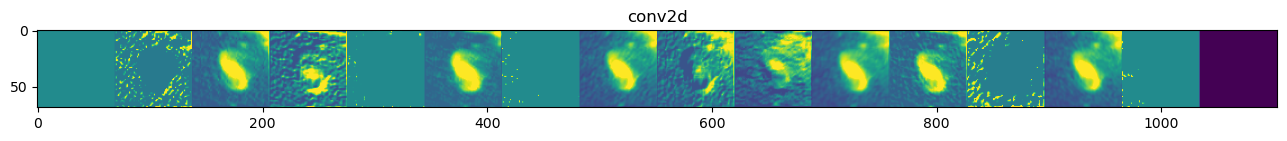

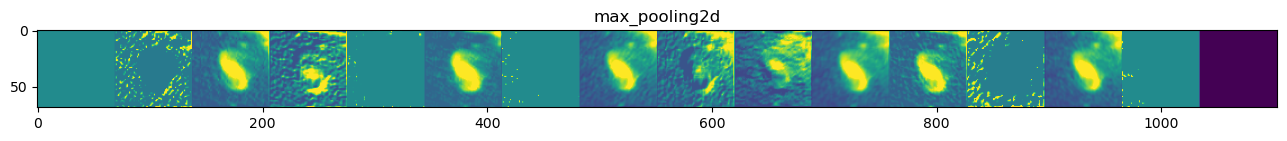

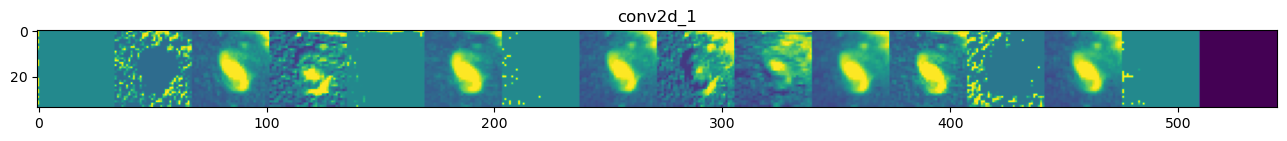

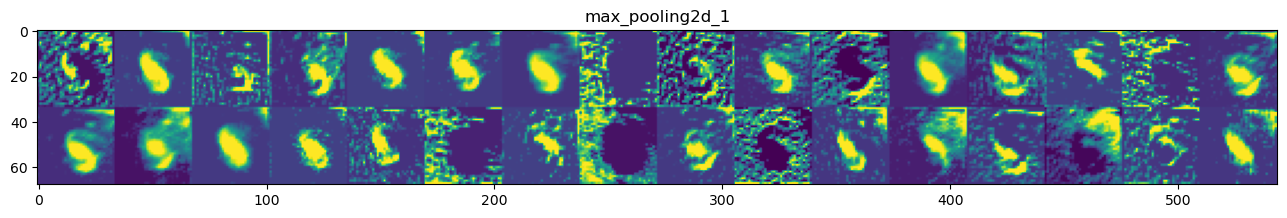

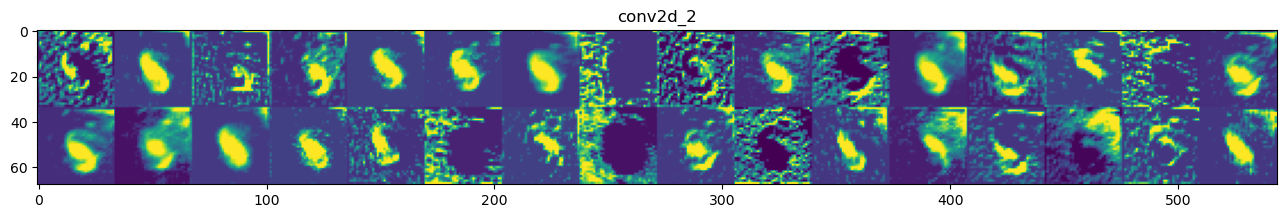

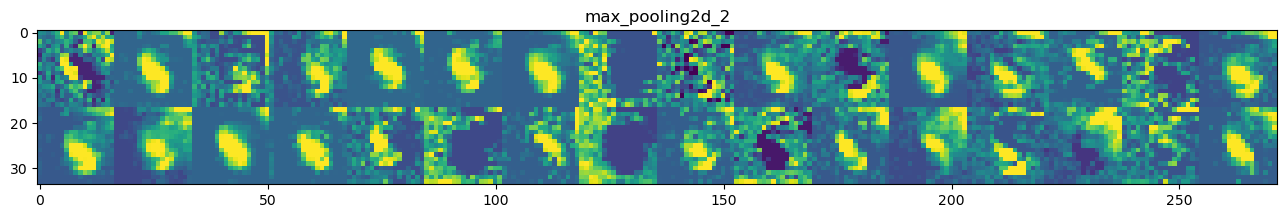

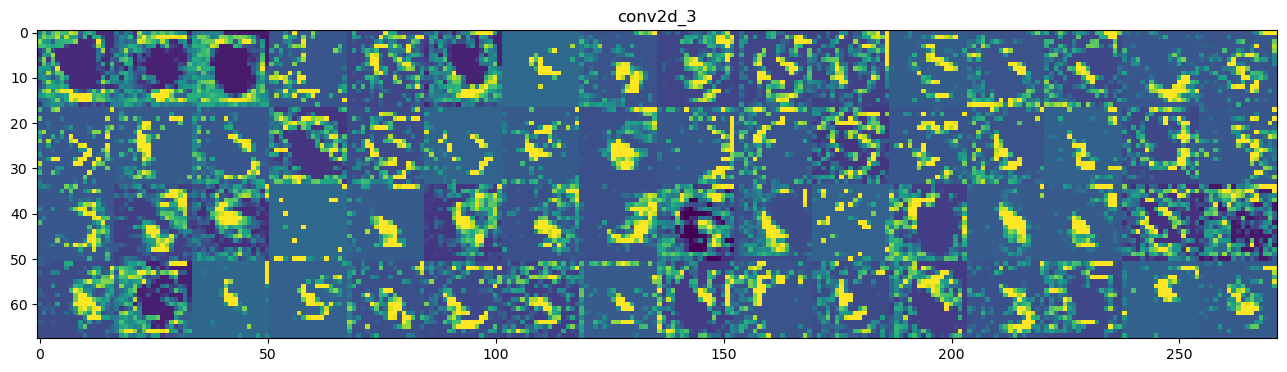

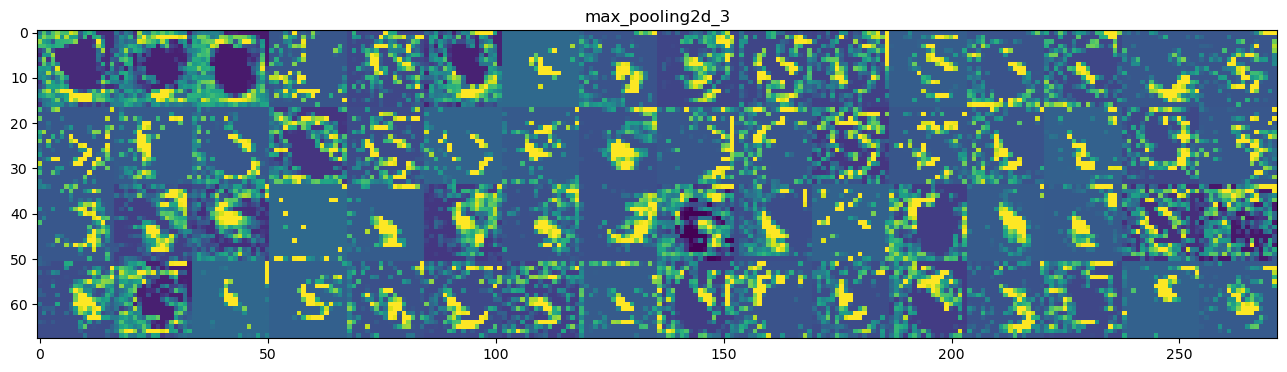

In [40]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] # number of features in the feature map
    size1 = layer_activation.shape[1]
    size2 = layer_activation.shape[2]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size1 * n_cols, images_per_row * size2))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size1 : (col + 1) * size1, row * size2 : (row + 1) * size2] = channel_image
    plt.figure(figsize=(1. /size1*display_grid.shape[1], 1. /size2*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')